In [1]:
import librosa
import numpy as np
import glob, os
from scipy.stats import iqr
import soundfile as sf

sr = 22050

def load_wav(directory, max_files = 15, sr = 22050):

    audio_files = []

    directory = directory
    max_files = max_files
    sr = sr

    for file_number in range(1, max_files + 1):
        directory_path = directory + str(f"/0{file_number}" if file_number < 10 else f"/{file_number}")
        wav_paths = glob.glob(os.path.join(directory_path, '*.wav'))
        audio_files += [librosa.load(wav_path, sr = sr)[0] for wav_path in wav_paths]

    max_length = sr
    audio_files = np.array([np.pad(arr, (0, max_length - len(arr)), 'constant') for arr in audio_files])
    return audio_files, sr




def get_spectrograms(data, hop_length = 512, frame_size = 2048):
    stfts = np.array([librosa.stft(y = y, hop_length = hop_length, n_fft = frame_size)[:-1] for y in data])
    specs = np.array([librosa.amplitude_to_db(S = np.abs(stft), ref = np.max) for stft in stfts])
    return specs

def extract_features(dataset, sr, n_mels=128, n_fft=2048, hop_length=512):
    mel_spec = np.array([librosa.feature.melspectrogram(y = data, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length) for data in dataset])
    mel_spec_db = np.array([librosa.power_to_db(spec, ref=np.max) for spec in mel_spec])
    return mel_spec_db

def normalize(data, type = 'standardization'):
    if type == 'standardization':
        return (data - data.mean()) / data.std()
    if type == 'minmax':
        #return (data - data.min()) / (data.max() - data.min()), data.min(), data.max()
        return np.array([(x - x.min()) / (x.max() - x.min()) for x in data]), data.min(), data.max()
    if type == 'robust':
        return np.array([(x - np.median(x)) / iqr(x) for x in data])
    if type == 'max':
        return data / np.max(np.abs(data))

def denormalize(data, min, max, type = 'standardization'):
    if type == 'minmax':
        denormalized_data = (data - data.min()) / (data.max() - data.min())
        return denormalized_data * (max - min) + min


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import L1, L2, L1L2

# Define the sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(8, (3, 3), strides = (2, 1), activation='relu', padding='valid')(inputs)
    x = layers.MaxPool2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), strides = (2, 1), activation='relu', padding='valid')(x)
    x = layers.MaxPool2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    return models.Model(inputs, [z_mean, z_log_var], name='encoder')

# Define the decoder
def build_decoder(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(output_shape), activation='relu', use_bias=True)(latent_inputs) # 10160
    x = layers.Reshape(target_shape = output_shape)(x) # (127, 20, 4)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (2, 3), strides = (1, 1), activation='relu', padding='valid')(x)
    x = layers.UpSampling2D((2, 2))(x)
    outputs = layers.Conv2DTranspose(1, (3, 4), strides = (1, 1), activation='relu', padding='valid', activity_regularizer = L2(0.01))(x)
    return models.Model(latent_inputs, outputs, name='decoder')


In [3]:
from tensorflow.keras.losses import KLDivergence, MeanSquaredError
from tensorflow.keras.models import Model

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.mse_loss = MeanSquaredError()
        self.kl_loss = KLDivergence()
        self._beta = 1
        self._reconstruction_loss_weight = 10000

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed

    def compute_loss(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        reconstruction_loss = self._reconstruction_loss_weight * self.mse_loss(inputs, reconstructed)
        kl_loss = self._beta * self.kl_loss(inputs, reconstructed)#-0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        total_loss = reconstruction_loss + kl_loss
        return total_loss, kl_loss, reconstruction_loss

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss, kl_loss, reconstruction_loss = self.compute_loss(data)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"total_loss": loss,
                "kl_loss": kl_loss,
                "reconstruction_loss": reconstruction_loss}
    
    def test_step(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        reconstruction_loss = self.mse_loss(inputs, reconstructed)
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = reconstruction_loss + kl_loss
        return {"total_loss" : total_loss}


In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

directory_path = "C:/Users/Admin/data/"
hop_length = 256
frame_size = 1024

y, sr = load_wav(directory_path, max_files = 3)
spectrograms = get_spectrograms(y, hop_length = hop_length, frame_size = frame_size)

In [5]:
X_train, X_test, _, _ = train_test_split(spectrograms, np.random.rand(y.shape[0],), random_state= 12, shuffle = True, test_size = 0.33)

X_train, train_min, train_max = normalize(X_train, type = 'minmax')
X_test, test_min, test_max = normalize(X_test, type = 'minmax')
X_train = X_train.reshape(*X_train.shape, 1)
X_test = X_test.reshape(*X_test.shape, 1)

In [6]:
# Instantiate and compile the VAE
input_shape = (512, 87, 1)  # Example input shape, should match your preprocessed data
latent_dim = 16
output_shape = (127, 20, 1)

encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim, output_shape)
vae = VAE(encoder, decoder)
batch_size = 32
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4))

In [7]:
import matplotlib.pyplot as plt
# Train the VAE
vae.fit(X_train, epochs=200, batch_size = batch_size, shuffle = True)
reconstructed_audio = vae.predict(X_test[:32])[1]

fig, ax = plt.subplots()
img = librosa.display.specshow(X_test[0].reshape(X_test[0].shape[0], X_test[0].shape[1]), x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

fig, ax = plt.subplots()
img = librosa.display.specshow(reconstructed_audio.reshape(reconstructed_audio.shape[0], reconstructed_audio.shape[1]), x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

sf.write("C:/Users/Admin/test_audio/audio.wav", librosa.griffinlim(denormalize(X_test[1, :, :, 0], test_min, test_max, type = 'minmax')), samplerate=sr)
sf.write("C:/Users/Admin/test_audio/audio_recon.wav", librosa.istft(denormalize(reconstructed_audio[:, :, 0], test_min, test_max, type = 'minmax')), samplerate = sr)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - kl_loss: 0.6128 - reconstruction_loss: 485.4101 - total_loss: 486.0229
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - kl_loss: 0.1592 - reconstruction_loss: 319.0951 - total_loss: 319.2544
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - kl_loss: 0.0687 - reconstruction_loss: 207.4329 - total_loss: 207.5016
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - kl_loss: 0.0504 - reconstruction_loss: 163.9762 - total_loss: 164.0266
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - kl_loss: 0.0456 - reconstruction_loss: 147.5556 - total_loss: 147.6012
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - kl_loss: 0.0431 - reconstruction_loss: 138.8796 - total_loss: 138.9226
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - kl_loss: 0.0411 - reconstruction_loss: 132.4424 - total_loss: 132.4834
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - kl_loss: 0.0394 - reconstruction_loss: 126.6560 - total_loss: 1

KeyboardInterrupt: 

In [ ]:
reconstructed_audio = vae.predict(X_test[:32])[9]
sf.write("C:/Users/Admin/test_audio/audio.wav", librosa.griffinlim(X_test[9, :, :, 0]), samplerate=sr)
sf.write("C:/Users/Admin/test_audio/audio_recon.wav", librosa.griffinlim(reconstructed_audio[:, :, 0]), samplerate = sr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


In [ ]:
#vae.save("C:/Users/Admin/test_audio/mymodel.keras")

In [ ]:
vae.summary()

Model: "vae_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ?                      │     2,759,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ ?                      │        43,789 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sampling_19 (Sampling)          │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,409,593 (32.08 MB)

 Trainable params: 2,803,197 (10.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,606,396 (21.39 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


ParameterError: Audio buffer is not finite everywhere

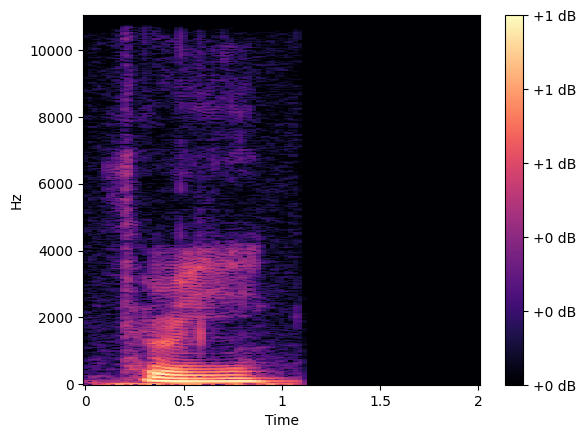

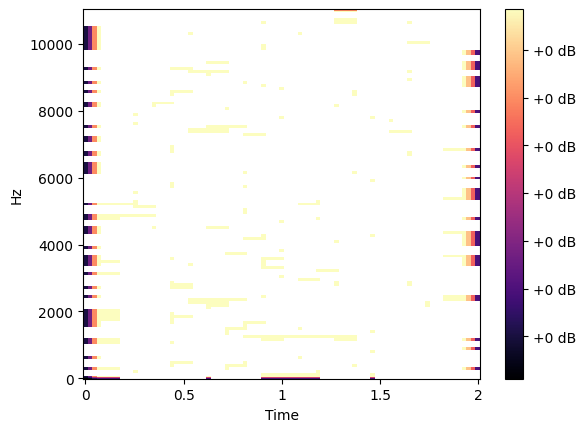

In [ ]:
import matplotlib.pyplot as plt

def reconstruct_audio(vae, audio_features):
    reconstructed_features = vae.predict(audio_features[np.newaxis, ..., np.newaxis])
    reconstructed_features = reconstructed_features[0, ..., 0]
    return reconstructed_features

fig, ax = plt.subplots()
img = librosa.display.specshow(X_test[0].reshape(X_test[0].shape[0], X_test[0].shape[1]), x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

reconstructed_audio = vae.predict(spectrograms[:122].reshape(*spectrograms[:122].shape, 1))[0]


fig, ax = plt.subplots()
img = librosa.display.specshow(reconstructed_audio.reshape(reconstructed_audio.shape[0], reconstructed_audio.shape[1]), x_axis='time', y_axis='linear', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

sf.write("C:/Users/Admin/test_audio/audio.wav", y[3] / y[3].max(), samplerate=sr)
sf.write("C:/Users/Admin/test_audio/audio_recon.wav", librosa.griffinlim(S = reconstructed_audio.reshape(reconstructed_audio.shape[0], reconstructed_audio.shape[1]), hop_length=hop_length, n_fft=frame_size), samplerate = sr)

In [ ]:
np.unique(reconstructed_audio)

array([0.52566963, 0.52807426, 0.52839875, 0.534643  , 0.5390312 ,
       0.53986186, 0.5407308 , 0.5449263 , 0.5499856 , 0.55330247,
       0.55632496, 0.5566463 , 0.5576602 , 0.5665275 , 0.57070655,
       0.57152545, 0.5789749 , 0.57978964, 0.60013604, 0.6090593 ,
       0.6352358 ,        nan], dtype=float32)

In [ ]:
def plot_spectrograms(original, reconstructed, sr, hop_length=512, n_fft=2048):
    # Original Spectrogram
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot original spectrogram
    img = librosa.display.specshow(librosa.amplitude_to_db(original, ref=np.max),
                                   sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', ax=axs[0])
    axs[0].set_title('Original Spectrogram')
    fig.colorbar(img, ax=axs[0], format="%+2.0f dB")
    
    # Plot reconstructed spectrogram
    img = librosa.display.specshow(librosa.amplitude_to_db(reconstructed, ref=np.max),
                                   sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', ax=axs[1])
    axs[1].set_title('Reconstructed Spectrogram')
    fig.colorbar(img, ax=axs[1], format="%+2.0f dB")
    
    plt.tight_layout()
    plt.show()

# Example usage
mel_spec = librosa.feature.melspectrogram(y = y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
normalized_features = normalize(mel_spec_db, type = 'standardization')

# Assuming `best_model` is your trained VAE model
reconstructed_features = reconstruct_audio(vae, normalized_features.reshape(*normalized_features.shape, 1))

# Plot the spectrograms
plot_spectrograms(mel_spec, reconstructed_features, sr)

ValueError: Exception encountered when calling VAE.call().

[1mas_list() is not defined on an unknown TensorShape.[0m

Arguments received by VAE.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)

In [ ]:
sf.write("C:/Users/Admin/test_audio/audio_recon.wav", reconstructed_audio, samplerate = sr)

In [ ]:
import keras_tuner as kt
tuner = kt.Hyperband(vae, objective = 'total_loss')

ValueError: Could not infer optimization direction ("min" or "max") for unknown metric "total_loss". Please specify the objective  asa `keras_tuner.Objective`, for example `keras_tuner.Objective("total_loss", direction="min")`.

In [ ]:
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ?                      │     2,919,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ ?                      │        36,353 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sampling (Sampling)             │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,866,181 (33.82 MB)

 Trainable params: 2,955,393 (11.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,910,788 (22.55 MB)